## Lab 2 -Pitfalls of retrieval - when simple vector search fails! 

In [1]:
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

model_O3.onnx:   0%|          | 0.00/436M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/110M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/110M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/110M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/110M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

openvino_model.xml: 0.00B [00:00, ?B/s]

openvino_model_qint8_quantized.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

openvino_model_qint8_quantized.xml: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

349

In [2]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/usr/local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [3]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [4]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [03:15<00:00,  1.79it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(-3.3378206849098206, 7.230811512470245, 5.923376560211182, 13.01902151107788)

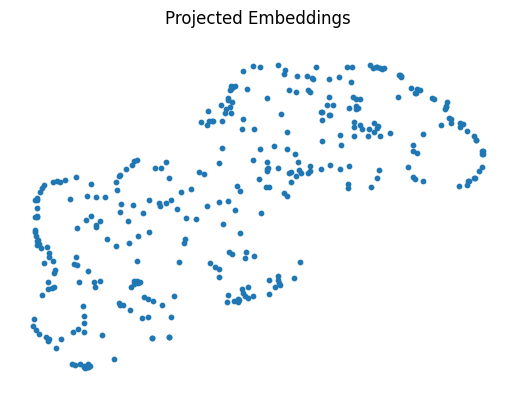

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## Relevancy and Distraction

In [6]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millio

In [7]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


(-3.3378206849098206, 7.230811512470245, 5.923376560211182, 13.01902151107788)

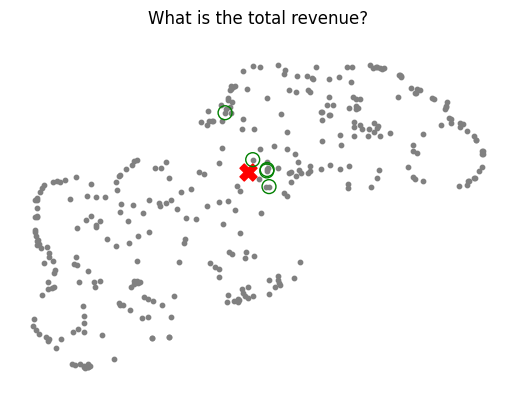

In [8]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [9]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

In [10]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


(-3.3378206849098206, 7.230811512470245, 5.923376560211182, 13.01902151107788)

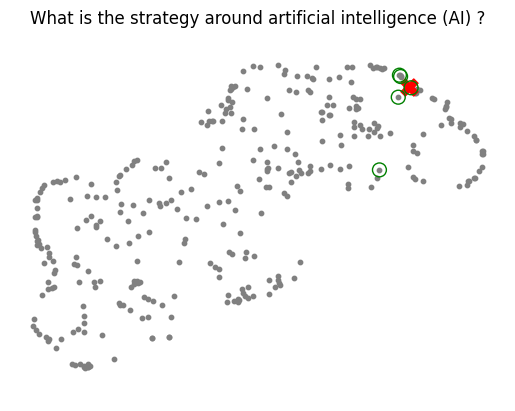

In [11]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [12]:
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing

competitive in local markets and enables us to continue to attract top
talent from ac

In [13]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


(-3.3378206849098206, 7.230811512470245, 5.923376560211182, 13.01902151107788)

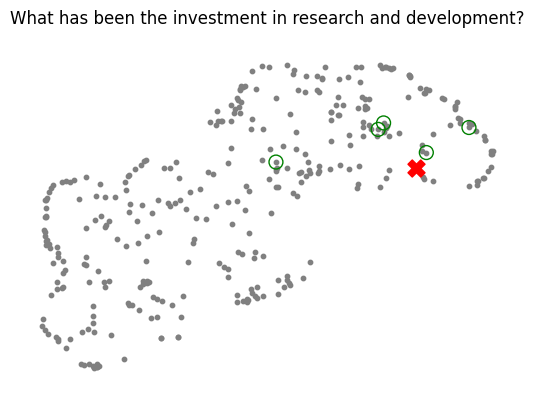

In [14]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [15]:
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

we use metrics in assessing the performance of our business and to make
informed decisions regarding the allocation of resources. we disclose
metrics to enable investors to evaluate progress against our ambitions,
provide transparency into performance trends, and reflect the continued
evolution of our products and services. our commercial and other
business metrics are fundamentally connected based on how customers use
our products and

18 total rewards we develop dynamic, sustainable, market - driven, and
strategic programs with the goal of providing a highly differentiated
portfolio to attract, reward, and retain top talent and enable our
employees to thrive. these programs reinforce our culture and values
such as collaboration and growth mindset. managers evaluate and
recommend rewards based on, for example, how well we leverage the work
of others and contribute to the success of our colleagues. we monitor
pay equity and career progress across multiple dimensions. as part of
our eff

In [16]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


(-3.3378206849098206, 7.230811512470245, 5.923376560211182, 13.01902151107788)

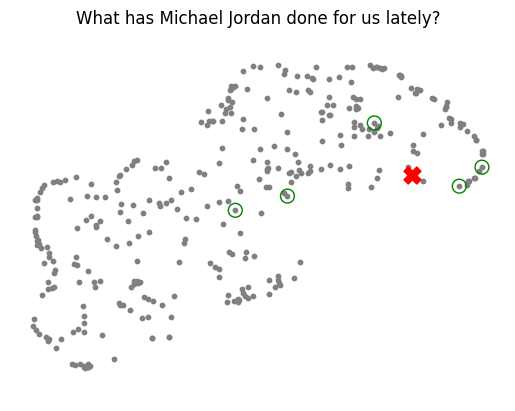

In [17]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')